<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Описание данных</a></span></li></ul></li><li><span><a href="#1.-Загрузка-данных" data-toc-modified-id="1.-Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Загрузка данных</a></span></li><li><span><a href="#2.-Умножение-матриц" data-toc-modified-id="2.-Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Умножение матриц</a></span></li><li><span><a href="#3.-Алгоритм-преобразования" data-toc-modified-id="3.-Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3. Алгоритм преобразования</a></span></li><li><span><a href="#4.-Проверка-алгоритма" data-toc-modified-id="4.-Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>4. Проверка алгоритма</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Требуется защитить данные клиентов страховой компании. Нужно разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию и обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

### Описание данных

- **Признаки:** пол, возраст и зарплата застрахованного, количество членов его семьи.
- **Целевой признак:** количество страховых выплат клиенту за последние 5 лет.

In [34]:
import pandas as pd
import numpy as np 
import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_absolute_error 

## 1. Загрузка данных

In [3]:
# читаем csv-файл и сохраняем в переменную df_full, дату используем, как индекс
try:
    df = pd.read_csv('/datasets/insurance.csv') #, index_col='date', parse_dates=True)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance.csv') #, index_col='date', 
                          #parse_dates=True) 

df.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2638,0,28.0,49200.0,3,0
2758,0,22.0,24500.0,0,0
2534,0,26.0,46700.0,0,0
2788,1,24.0,41300.0,1,0
4264,1,42.0,52600.0,0,1


In [4]:
df.info() # пропусков нет, форматы данных адекватные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
df.describe() # явных аномалий с числовых данных не наблюдается

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


<AxesSubplot:>

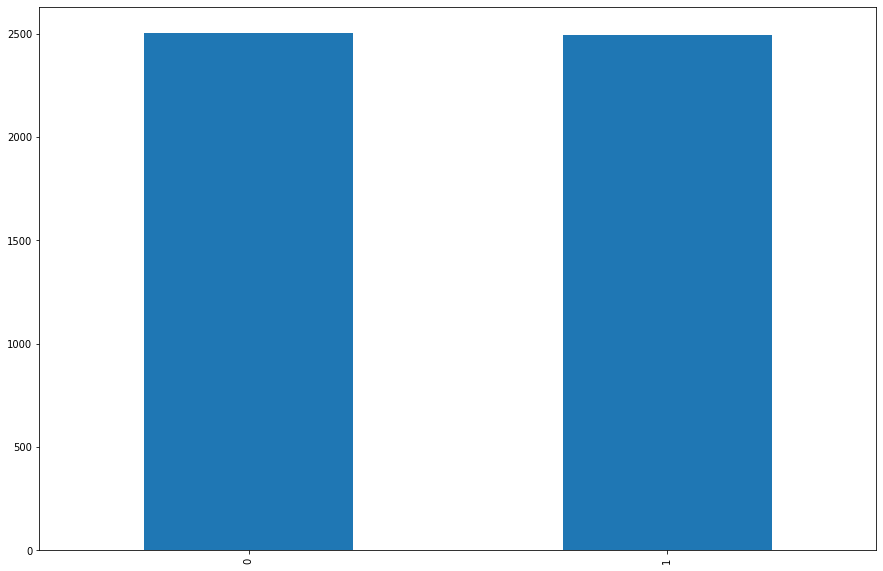

In [37]:
df['Пол'].value_counts().plot(kind='bar', figsize=(15, 10))

<AxesSubplot:ylabel='Frequency'>

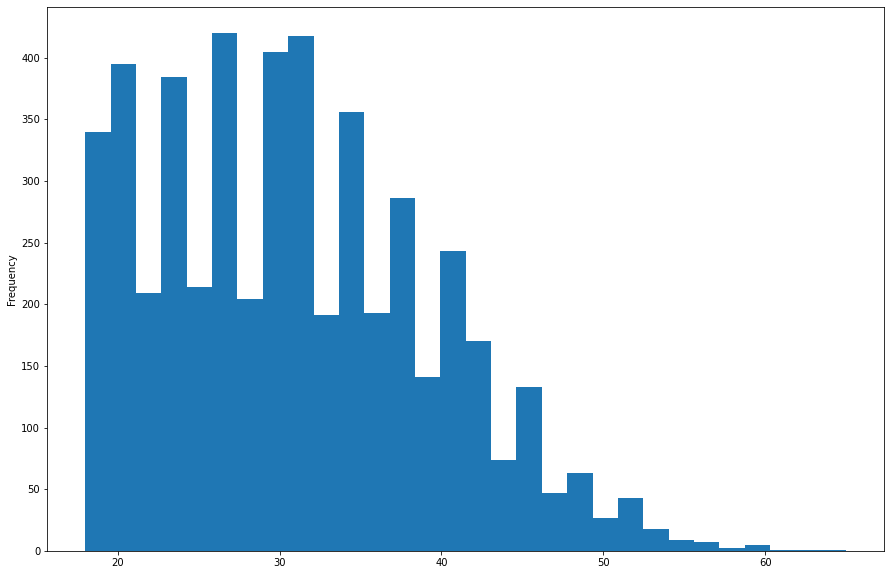

In [13]:
df['Возраст'].plot(kind='hist', bins=30, figsize=(15, 10))

<AxesSubplot:ylabel='Frequency'>

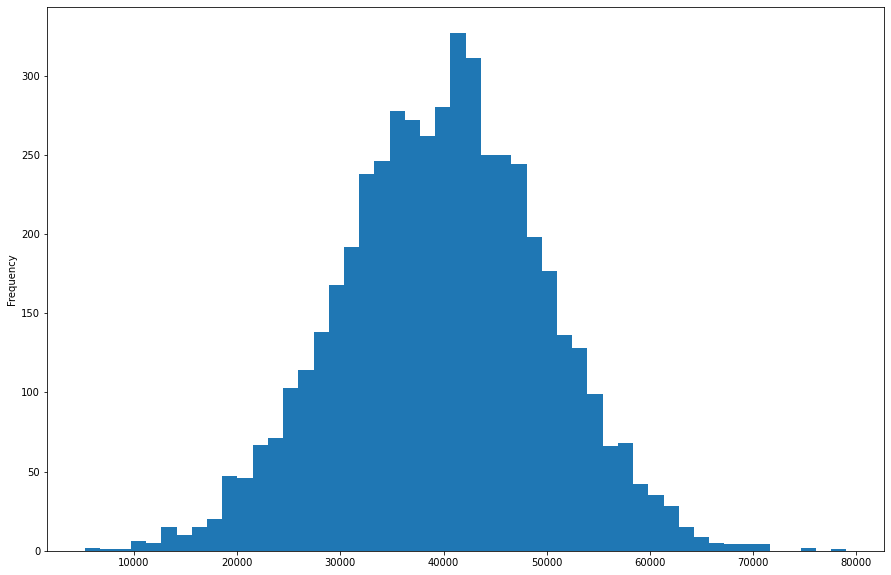

In [19]:
df['Зарплата'].plot(kind='hist', bins=50, figsize=(15, 10))

<AxesSubplot:>

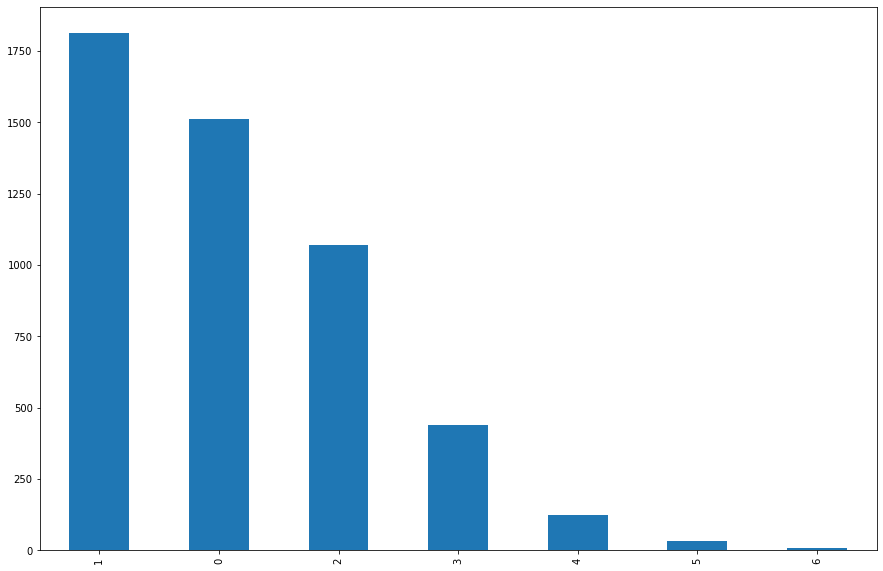

In [32]:
df['Члены семьи'].value_counts().plot(kind='bar', figsize=(15, 10))

<AxesSubplot:>

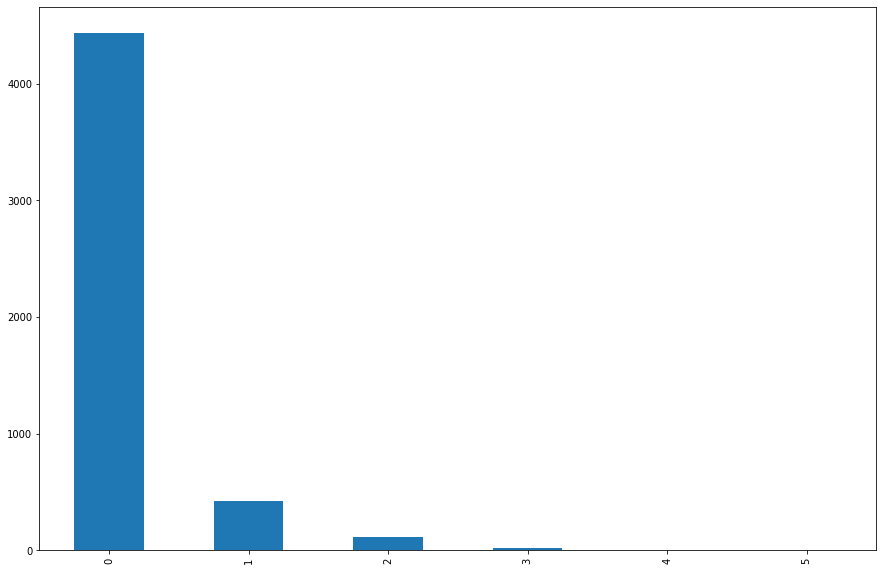

In [30]:
df['Страховые выплаты'].value_counts().plot(kind='bar', figsize=(15, 10))

In [33]:
# так как не все количественные признаки распределены нормально, для оценки корреляции выбираем метод 'spearman'
df.drop(['Пол'], axis=1).corr(method='spearman') # высоких значений корреляции между фичами не наблюдается, а вот целевой 
# признак заметно коррелирует с одной из фичей (возрастом), что хорошо для линейной модели

,Возраст,Зарплата,Члены семьи,Страховые выплаты
Возраст,1.000000,-0.020238,-0.001503,0.548589
Зарплата,-0.020238,1.000000,-0.025492,-0.005549
Члены семьи,-0.001503,-0.025492,1.000000,-0.029210
Страховые выплаты,0.548589,-0.005549,-0.029210,1.000000


<AxesSubplot:>

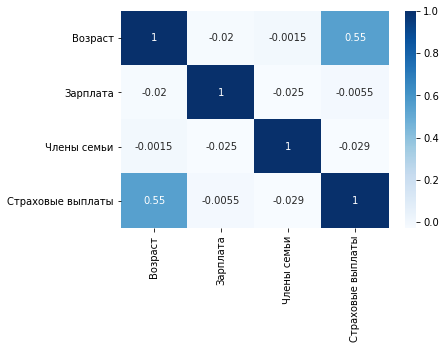

In [35]:
corr = df.drop(['Пол'], axis=1).corr(method='spearman')
sns.heatmap(corr, cmap="Blues", annot=True)

In [6]:
print(f'Доля дубликатов среди всех данныз: {100 * df.duplicated().sum() / len(df)} %')

Доля дубликатов среди всех данныз: 3.06 %


**Вывод:** Имеем 5000 строк, пропусков нет, форматы данных адекватные, аномалий не наблюдается, рисков мультиколлинеарности нет, есть 3% полных дубликатов в данных, но у нас нет уникальных ID клиентов, так что одинаковые фичи для разных клиентов допустимы, тем более их небольшая доля, так что не будем их удалять. Можем двигаться дальше.

In [7]:
features = df.drop(['Страховые выплаты'], axis=1) 
target = df['Страховые выплаты']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) # отделяем 25% данных для тестовой выборки

## 2. Умножение матриц

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Не изменится. Рассмотрим, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

**Обоснование:** Итак, нам нужно домножить матрицу признаков на случайную обратимую матрицу $P$ (соответственно она должна быть квадратнойи и иметь размерность, равную количеству признаков, чтобы после произведения иметь такое же кол-во признаков), изучить взаимосвязь параметров и сравнить качество линейной регрессии до и после.              

Новые предсказания будут получаться по формуле:

$$
a_p = XPw_p
$$

Формула переобучения на новых признаках:

$$
w_p = ((XP)^TXP)^{-1} (XP)^T y
$$
Преобразуем:
$$
w_p = (P^T(X^TX)P)^{-1} P^TX^T y
$$
Еще:
$$
w_p = P^{-1} (X^TX)^{-1} (P^T)^{-1}  P^TX^T y
$$
Но:
$$
(P^T)^{-1} P^T = E
$$
Соответственно:
$$
w_p = P^{-1} (X^TX)^{-1} X^T y = P^{-1} ((X^TX)^{-1} X^T y)
$$
Однако:
$$
w = (X^TX)^{-1} X^T y
$$
Значит w_p можно представить через w:
$$
w_p = P^{-1}w
$$
Таким образом:
$$
a_p = XPw_p = XPP^{-1}w = XEw = Xw = a
$$

**Вывод:** Получается, что предсказания на преобразованных признаках равны предсказаниям на изначальных, если преобразование делается путем умножения признаков на обратимую матрицу.

## 3. Алгоритм преобразования

**Алгоритм**

Матрицу признаков домножаем на рандомную обратимую матрицу с размерностью, соответствующей количеству признаков. Получаем набор данных, не отражающих реальные данные клиентов, тем не менее позволяющий получить предсказания целевого признака на не худшем уровне качества. Для обратной расшифровки данных достаточно домножить имеющуюся матрицу данных на матрицу, обратную той, что использовалась для преобразования.

**Обоснование**

Домножение признаков на обратимую матрицу не влияет на предсказания модели при переобучении на новых признаках (см. обоснование выше).

## 4. Проверка алгоритма

Запрограммируем этот алгоритм, применив матричные операции. Проверим, что качество линейной регрессии из sklearn не отличается до и после преобразования. Применим метрику R2.

In [8]:
model = LinearRegression() # берем модель линейной регрессии из библиотеки sklearn, обучаем и проверяем метрику R2
model.fit(features_train, target_train)
print("Метрика R2 для линейной регрессии на незашифрованных признаках:", r2_score(target_test, model.predict(features_test)))

Метрика R2 для линейной регрессии на незашифрованных признаках: 0.43522757127026546


In [9]:
n = features.shape[1] 
random_matrix = np.random.randn(n,n) # строим матрицу из рандомных чисел размерностью в соответствии с кол-вом признаков

In [10]:
try:
    inverse_matrix = np.linalg.inv(random_matrix)
    print('\nМатрица обратима - можно продолжать')
except:
    print('\nМатрица необратима - требуется сгенерировать новую')  #нужно убедиться, что матрица обратима


Матрица обратима - можно продолжать


In [41]:
features_train_encrypted = features_train @ random_matrix  #преобразовываем признаки
features_test_encrypted = features_test @ random_matrix

In [42]:
model.fit(features_train_encrypted, target_train)       #смотрим метрику той же можели на преобразованных данных
print("Метрика R2 для линейной регрессии на незашифрованных признаках:", \
      r2_score(target_test, model.predict(features_test_encrypted)))

Метрика R2 для линейной регрессии на незашифрованных признаках: 0.4352275712700211


**Вывод:** Метрика R2 до и после преобразования отличается незначительно. 

In [43]:
#проверим методику дешифровки:
features_train_decrypted = features_train_encrypted @ inverse_matrix
print('Значение средней абсолютной ошибки между признаками до преобразования и после дешифровки составляет:', \
      mean_absolute_error(features_train, features_train_decrypted))

Значение средней абсолютной ошибки между признаками до преобразования и после дешифровки составляет: 3.8738297310677205e-12


**Вывод:** Значение средней абсолютной ошибки между признаками до преобразования и после дешифровки ничтожно мало.